In [1]:
from dask.distributed import Client

client = Client(n_workers=4)

In [2]:
import dask.dataframe as dd
import pandas as pd
import math

In [3]:
# Read parquet files in as set of dataframes
df = dd.read_parquet("s3://airflow-test-data/e0a14dbf-e8e6-42bd-b908-e72a956fadd5/749916f0-be24-4e4b-9a6c-798808a5be3c/*.parquet",
    storage_options={
        "anon": False,
        "use_ssl": False,
        "key":"foobar",
        "secret":"foobarbaz",
        "client_kwargs":{
            "region_name":"us-east-1",
            "endpoint_url":"http://10.64.18.141:9000"
        }
    })
# Read parquet files in as set of dataframes
# df = dd.read_parquet("data/3fd5794e-f7d3-4fcf-922b-652c93853caa/2f3e4c71-e296-4944-aba6-8d4eb063a23e/*.parquet")

In [4]:
df = df.astype({'value': 'float64'})
df.dtypes
# Just simply partition the file based on the size to run operations in distrubed manner (this might not be ideal way to partition data and this is just an experiment)
df = df.repartition(partition_size="5MB")

In [5]:
# Convert lat, long to tile
def deg2num(lat_deg, lon_deg, zoom):
  lat_rad = math.radians(lat_deg)
  n = 2.0 ** zoom
  xtile = int((lon_deg + 180.0) / 360.0 * n)
  ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
  return (zoom, xtile, ytile)

def parentTile(coord):
    z, x, y = coord
    return (z - 1, math.floor(x / 2), math.floor(y / 2))

# A tile will contain up to 4^levelDiff number of subtiles
def tileCoord(subTileCoord, levelDiff = 5):
    z, x, y = subTileCoord
    return (z - 5, math.floor(x / math.pow(2, levelDiff)), math.floor(y / math.pow(2, levelDiff)))

CPU times: user 106 ms, sys: 18.5 ms, total: 124 ms
Wall time: 1.27 s


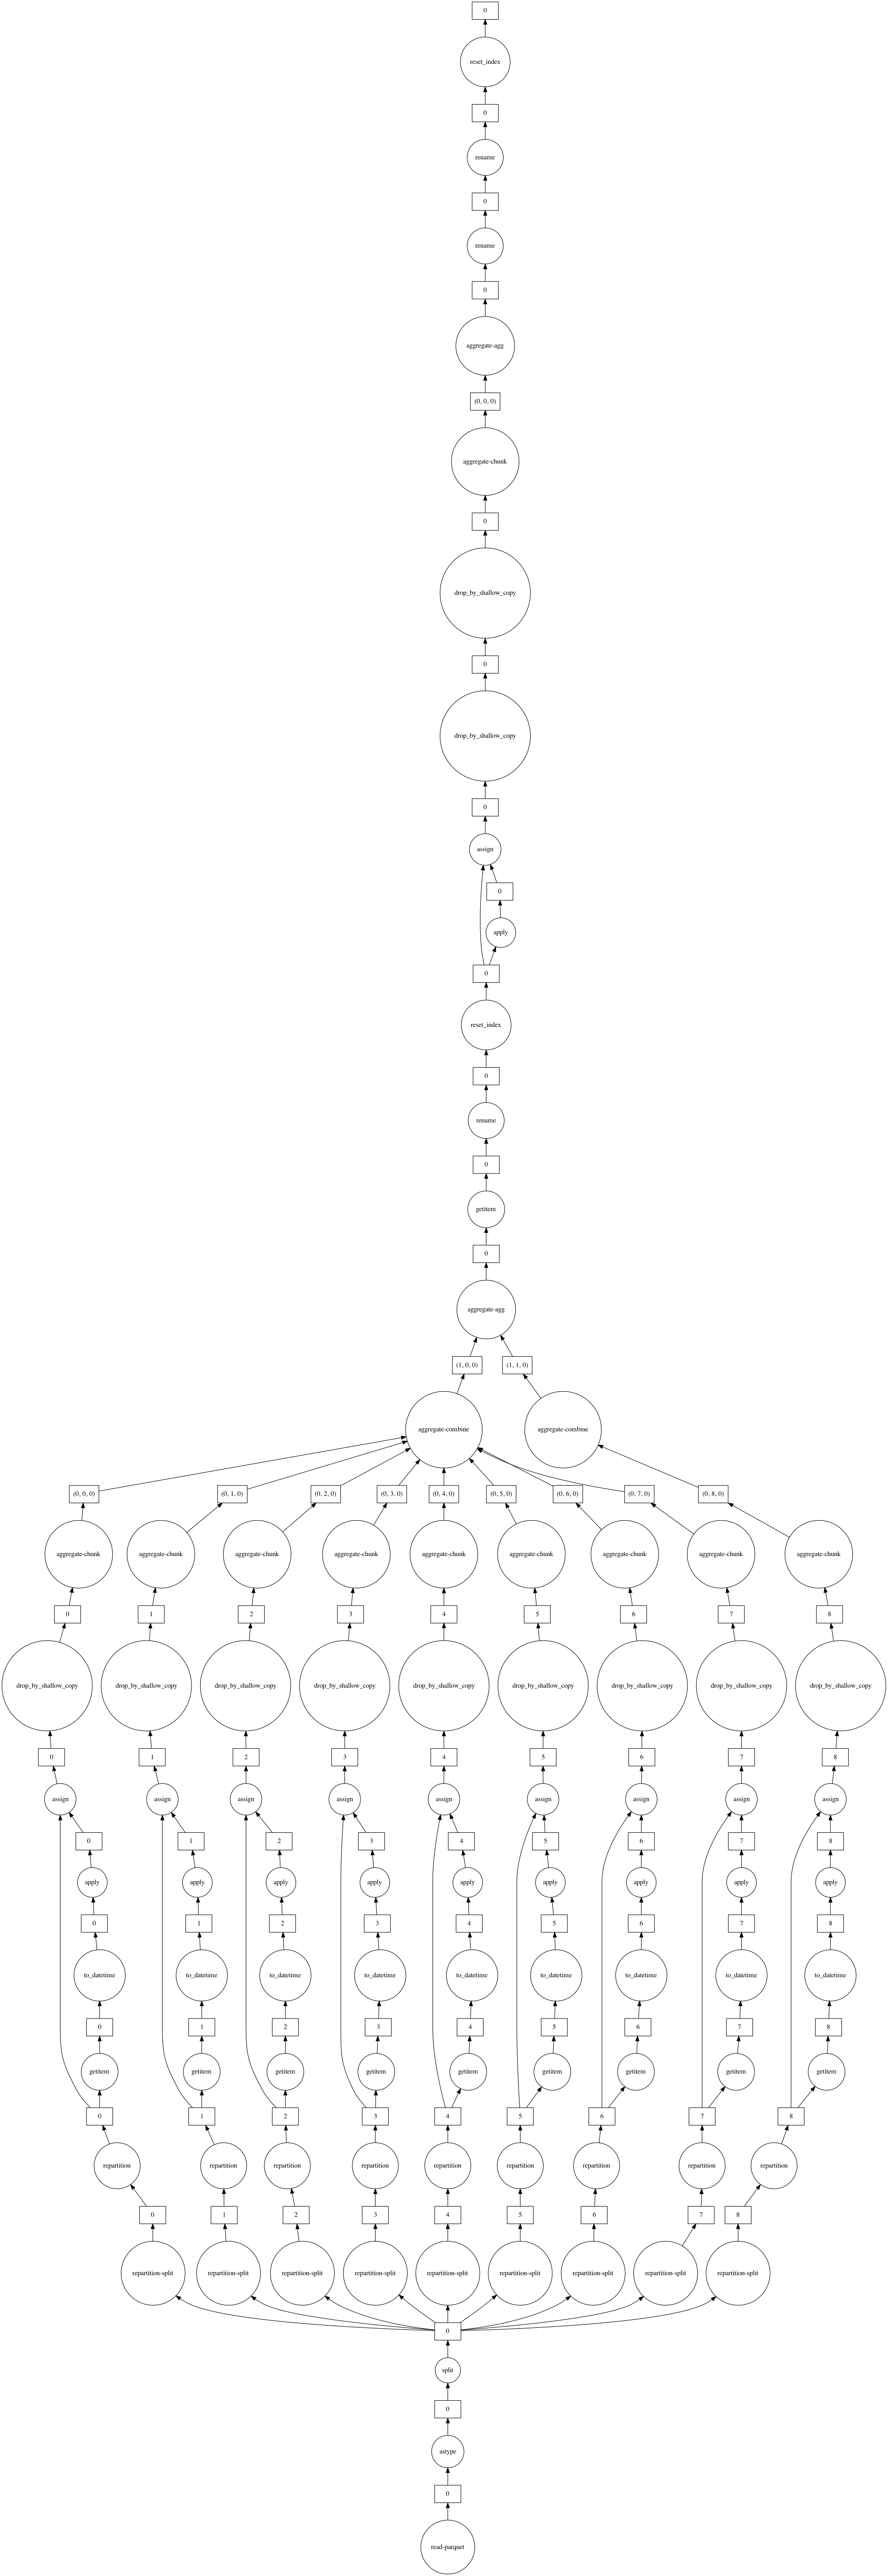

In [6]:
%%time
# ==== Prepare data and run temporal and spatial aggregation =====

# Temporal aggregation (compute for both sum and mean)
df['yearmonth'] = dd.to_datetime(df['timestamp']).apply(lambda x: '{year}-{month}'.format(year=x.year, month=x.month), meta=(None, 'object'))
df = df.drop('timestamp', axis=1)
df = df.groupby(['feature', 'yearmonth', 'lat', 'lng'])['value'].agg(['sum', 'mean'])

# Rename agg column names
df.columns = df.columns.str.replace('sum', 't_sum').str.replace('mean', 't_mean')
df = df.reset_index()
    
# Spatial aggregation to higest supported precision(subtile z) level (10)
df['subtile'] = df.apply(lambda x: deg2num(x.lat, x.lng, 10), axis=1, meta=(None, 'object'))

# Drop unnecessary columns
df = df.drop('lat', axis=1)
df = df.drop('lng', axis=1)

# Compute for both sum and mean for each values (temporal sum and mean)
df = df.groupby(['feature', 'yearmonth', 'subtile']).agg(['sum', 'mean'])
    
# Rename columns
lookup = {('t_sum', 'sum'): 't_sum_s_sum', ('t_sum', 'mean'): 't_sum_s_mean', ('t_mean', 'sum'): 't_mean_s_sum', ('t_mean', 'mean'): 't_mean_s_mean'}
df.columns = df.columns.to_flat_index()
df = df.rename(columns=lookup)
df = df.reset_index()

df.visualize()

In [7]:
%%time
df.compute()

CPU times: user 278 ms, sys: 48.8 ms, total: 327 ms
Wall time: 6.83 s


,feature,yearmonth,subtile,t_sum_s_sum,t_sum_s_mean,t_mean_s_sum,t_mean_s_mean
0,harvest,1970-1,"(10, 0, 218)",0.0,0.0,0.0,0.0
1,harvest,1970-1,"(10, 0, 222)",0.0,0.0,0.0,0.0
2,harvest,1970-1,"(10, 0, 239)",0.0,0.0,0.0,0.0
3,harvest,1970-1,"(10, 0, 243)",0.0,0.0,0.0,0.0
4,harvest,1970-1,"(10, 0, 246)",0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
202255,irrigation water,1970-1,"(10, 1023, 339)",0.0,0.0,0.0,0.0
202256,irrigation water,1970-1,"(10, 1023, 542)",0.0,0.0,0.0,0.0
202257,irrigation water,1970-1,"(10, 1023, 558)",0.0,0.0,0.0,0.0
202258,irrigation water,1970-1,"(10, 1023, 560)",0.0,0.0,0.0,0.0


In [8]:
def processTiles(df, level):
    # Implement this
    print ("NYI: convert tiles to protobuf files")
    print ("NYI: saves protobuf tile files to disk in parallel")
    # For now just write current results as a whole to a file
    df.to_csv('./output/results-' + str(level) + '-*.csv')  

In [9]:
%%time
df['tile'] = df.apply(lambda x: tileCoord(x.subtile), axis=1, meta=(None, 'object'))
processTiles(df, 10)

df.compute()

convert tiles to protobuf files
saves protobuf tile files to disk in parallel
CPU times: user 702 ms, sys: 111 ms, total: 813 ms
Wall time: 19.2 s


,feature,yearmonth,subtile,t_sum_s_sum,t_sum_s_mean,t_mean_s_sum,t_mean_s_mean,tile
0,harvest,1970-1,"(10, 0, 218)",0.0,0.0,0.0,0.0,"(5, 0, 6)"
1,harvest,1970-1,"(10, 0, 222)",0.0,0.0,0.0,0.0,"(5, 0, 6)"
2,harvest,1970-1,"(10, 0, 239)",0.0,0.0,0.0,0.0,"(5, 0, 7)"
3,harvest,1970-1,"(10, 0, 243)",0.0,0.0,0.0,0.0,"(5, 0, 7)"
4,harvest,1970-1,"(10, 0, 246)",0.0,0.0,0.0,0.0,"(5, 0, 7)"
...,...,...,...,...,...,...,...,...
202255,irrigation water,1970-1,"(10, 1023, 339)",0.0,0.0,0.0,0.0,"(5, 31, 10)"
202256,irrigation water,1970-1,"(10, 1023, 542)",0.0,0.0,0.0,0.0,"(5, 31, 16)"
202257,irrigation water,1970-1,"(10, 1023, 558)",0.0,0.0,0.0,0.0,"(5, 31, 17)"
202258,irrigation water,1970-1,"(10, 1023, 560)",0.0,0.0,0.0,0.0,"(5, 31, 17)"


In [10]:
%%time
for i in range(5):
    df.compute()
    print ("Done Processing z=" + str(10 - i) + " subtiles")
    df['subtile'] = df.apply(lambda x: parentTile(x.subtile), axis=1, meta=(None, 'object'))
    df = df.groupby(['feature', 'yearmonth', 'subtile']).agg({ 't_sum_s_sum': 'sum', 't_mean_s_sum': 'sum', 't_sum_s_mean': 'mean', 't_mean_s_mean': 'mean'})
    df = df.reset_index()
    df['tile'] = df.apply(lambda x: tileCoord(x.subtile), axis=1, meta=(None, 'object'))
    processTiles(df, 10 - i - 1)
df.compute()
    

Done Processing z=10 subtiles
convert tiles to protobuf files
saves protobuf tile files to disk in parallel
Done Processing z=9 subtiles
convert tiles to protobuf files
saves protobuf tile files to disk in parallel
Done Processing z=8 subtiles
convert tiles to protobuf files
saves protobuf tile files to disk in parallel
Done Processing z=7 subtiles
convert tiles to protobuf files
saves protobuf tile files to disk in parallel
Done Processing z=6 subtiles
convert tiles to protobuf files
saves protobuf tile files to disk in parallel
CPU times: user 5.02 s, sys: 764 ms, total: 5.78 s
Wall time: 2min 51s


,feature,yearmonth,subtile,t_sum_s_sum,t_mean_s_sum,t_sum_s_mean,t_mean_s_mean,tile
0,harvest,1970-1,"(5, 0, 6)",0.0,0.0,0.0,0.0,"(0, 0, 0)"
1,harvest,1970-1,"(5, 0, 7)",0.0,0.0,0.0,0.0,"(0, 0, 0)"
2,harvest,1970-1,"(5, 0, 8)",0.0,0.0,0.0,0.0,"(0, 0, 0)"
3,harvest,1970-1,"(5, 0, 9)",0.0,0.0,0.0,0.0,"(0, 0, 0)"
4,harvest,1970-1,"(5, 0, 10)",0.0,0.0,0.0,0.0,"(0, 0, 0)"
...,...,...,...,...,...,...,...,...
1342,irrigation water,1970-1,"(5, 31, 16)",0.0,0.0,0.0,0.0,"(0, 0, 0)"
1343,irrigation water,1970-1,"(5, 31, 17)",0.0,0.0,0.0,0.0,"(0, 0, 0)"
1344,irrigation water,1970-1,"(5, 31, 19)",0.0,0.0,0.0,0.0,"(0, 0, 0)"
1345,irrigation water,1970-1,"(5, 31, 20)",0.0,0.0,0.0,0.0,"(0, 0, 0)"
